# University Ranking Prediction

Mission: Find a good model that could be used by university administrators to see how certain changes could affect their ranking.

<img src="university_campus.jpg" alt="University Campus" width="600px">

### Importing the libraries

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import folium
from folium.plugins import HeatMap, HeatMapWithTime
import matplotlib.pyplot as plt
import seaborn as sns
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles, Polyline, Popup
from ipywidgets import HTML
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.linear_model import Ridge
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import SGDRegressor 
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

## Importing the dataset

In [2]:
df = pd.read_csv('timesData.csv')
df = df.drop('total_score', axis=1)
df.iloc[:4, [0,1,2,3,4,8, 9, 10, 11, 12]].head(2)

,world_rank,university_name,country,teaching,international,num_students,student_staff_ratio,international_students,female_male_ratio,year
0,1,Harvard University,United States of America,99.7,72.4,"20,152",8.9,25%,NaN,2011
1,2,California Institute of Technology,United States of America,97.7,54.6,"2,243",6.9,27%,33 : 67,2011


In [3]:
df.shape

(2603, 13)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   world_rank              2603 non-null   object 
 1   university_name         2603 non-null   object 
 2   country                 2603 non-null   object 
 3   teaching                2603 non-null   float64
 4   international           2603 non-null   object 
 5   research                2603 non-null   float64
 6   citations               2603 non-null   float64
 7   income                  2603 non-null   object 
 8   num_students            2544 non-null   object 
 9   student_staff_ratio     2544 non-null   float64
 10  international_students  2536 non-null   object 
 11  female_male_ratio       2370 non-null   object 
 12  year                    2603 non-null   int64  
dtypes: float64(4), int64(1), object(8)
memory usage: 264.5+ KB


Most of the independent variables has object dtype, which needs to be converted to float or int dtype. This comes from the result of variables being tied, written as "=x" where x is the shared position. An example would be in the world rank column, "=601" means tied 601^th place.

## Feature Engineering

In [5]:
df_new = df[df['year'] == df['year'].max()].copy()
df_new = df_new.reset_index(drop=True)

In [6]:
df_ties = df_new[df_new['world_rank'].str.contains("=")].copy()

In [7]:
df_large_ties = df_new[df_new['world_rank'].str.contains("601-")].copy()

In [8]:
df_new['world_rank'] = df_new['world_rank'].str.replace('=', '')
df_new['world_rank'] = df_new['world_rank'].str.extract('([0-9]*)', expand=False)
df_new['world_rank'] = pd.to_numeric(df_new['world_rank'])
df_new['international'] = pd.to_numeric(df_new['international'])
df_new['income'] = df_new['income'].replace('-', np.nan)
df_new['income'] = pd.to_numeric(df_new['income'])
df_new['num_students'] = df_new['num_students'].str.replace(',', '')
df_new['num_students'] = pd.to_numeric(df_new['num_students'])
df_new['international_students'] = df_new['international_students'].str.replace('%', '')
df_new['international_students'] = pd.to_numeric(df_new['international_students'])
df_new['female_male_ratio'] = df_new['female_male_ratio'].replace('-', np.nan)
df_new['female_ratio'] = df_new['female_male_ratio'].str.extract('([0-9]*)')
df_new['female_ratio'] = pd.to_numeric(df_new['female_ratio'])
df_new = df_new.drop(['female_male_ratio', 'year'], axis=1)

In [9]:
nan_val_columns = ['num_students', 'student_staff_ratio', 'international_students', 'female_ratio',
                  'income']
for col in nan_val_columns:
    df_new[col] = df_new[col].fillna(method='bfill').fillna(method='ffill')

## Finding University coordinates (for the map visualizations)

In [10]:
# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent='myapplication')

In [11]:
# def precise_loc(institution):
#     try:
#         location = geolocator.geocode(institution)
#         return (location.raw['lat'], location.raw['lon'])
#     except:
#         print(institution)
#         return np.nan

### Dropping the values that Geopy cannot find

In [12]:
#precise_loc_vec = np.vectorize(precise_loc)

In [13]:
# not_found_list = ['ETH Zurich – Swiss Federal Institute of Technology Zurich', 
#                  'Wageningen University and Research Center',
#                 'Free University of Berlin']

In [14]:
# df_new[df_new['university_name'].isin(not_found_list)].index

In [15]:
# df_new = df_new.drop(df_new[df_new['university_name'].isin(not_found_list)].index)

In [16]:
# geo_coords = precise_loc_vec(df_new.iloc[:100,1].values)

In [17]:
# arr_lat = list()
# arr_lon = list()
# for i in range(len(df_new)):
#     try:
#         arr_lat.append(geo_coords[0][i])
#         arr_lon.append(geo_coords[1][i])
#     except:
#         arr_lat.append(np.nan)
#         arr_lon.append(np.nan)

In [18]:
# df_new['latitude'] = arr_lat
# df_new['longitude'] = arr_lon

#### Exporting the dataset, and importing, since the api takes a while

In [19]:
#df_coord =df_new.to_csv('top_100_with_coordinates.csv')

In [20]:
df_new = pd.read_csv('top_100_with_coordinates.csv')

In [21]:
df_new = df_new.reset_index(drop=True)

In [22]:
df_new = df_new.drop(columns=df_new.columns[0])

In [23]:
df_heatmap = df_new.iloc[:100, [-2, -1, 0]].copy() 

### Flipping the values for the heatmap

In [24]:
df_heatmap.columns

Index(['latitude', 'longitude', 'world_rank'], dtype='object')

In [25]:
df_heatmap = df_heatmap.rename(columns={'Unnamed: 0': 'world_rank'})

In [26]:
df_heatmap.world_rank = abs(100 - df_heatmap.world_rank)

In [27]:
hm = folium.Map(tiles='stamentoner',
               zoom_start=3.4)
title_html = '''
             <h3 align="center" style="font-size:16"><b>{}</b></h3>
             '''.format('Heatmap Over the Best Ranked Universities in Europe')   

HeatMap(df_heatmap, min_opacity=0.2, blur=12).add_to(folium.FeatureGroup().add_to(hm))
folium.LayerControl().add_to(hm)

hm.get_root().html.add_child(folium.Element(title_html))

hm

By zooming in on Europe, we can see that the UK has the best or most top ranked universities in Europe, so in this report UK and Europe have been splitted.

In [28]:
import pycountry_convert as pc

def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    
    except:
        raise ValueError(country_name)

#### Changing some spelling errors in the dataset

In [29]:
df.country = df.country.replace('Republic of Ireland', 'Ireland')

In [30]:
vec_country_to_continent = np.vectorize(country_to_continent)

In [31]:
df.loc[df.country == 'Unisted States of America', 'country'] = 'United States of America'
df.loc[df.country == 'Unted Kingdom', 'country'] = 'United Kingdom'
continent = vec_country_to_continent(df.country)
df['continent'] = continent

In [32]:
df.loc[df.country == 'United Kingdom', 'continent'] = 'UK'

In [33]:
df.continent = df.continent.astype('category')

In [34]:
df = pd.concat([df, pd.get_dummies(df.continent)], axis=1)

### Rechanging the columns, so it's more convenient in the ML section

In [35]:
cols = df.columns.to_list()

In [36]:
cols.remove('year')
cols.remove('continent')

In [37]:
cols.insert(1, 'year')

In [38]:
df = df[cols]

In [39]:
df['world_rank'] = df['world_rank'].str.replace('=', '')
df['world_rank'] = df['world_rank'].str.extract('([0-9]*)', expand=False)
df['world_rank'] = pd.to_numeric(df['world_rank'])
df['international'] = df['international'].str.replace('-', '')
df['international'] = pd.to_numeric(df['international'])
df['income'] = df['income'].replace('-', np.nan)
df['income'] = pd.to_numeric(df['income'])
df['num_students'] = df['num_students'].str.replace(',', '')
df['num_students'] = pd.to_numeric(df['num_students'])
df['international_students'] = df['international_students'].str.replace('%', '')
df['international_students'] = pd.to_numeric(df['international_students'])
df['female_male_ratio'] = df['female_male_ratio'].replace('-', np.nan)
df['female_ratio'] = df['female_male_ratio'].str.extract('([0-9]*)')
df['female_ratio'] = pd.to_numeric(df['female_ratio'])
df = df.drop(['female_male_ratio'], axis=1)

In [40]:
df.describe()

,world_rank,year,teaching,international,research,citations,income,num_students,student_staff_ratio,international_students,Africa,Asia,Europe,North America,Oceania,South America,UK,female_ratio
count,2603.000000,2603.000000,2603.000000,2594.000000,2603.000000,2603.000000,2385.000000,2544.000000,2544.000000,2536.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2367.000000
mean,234.991164,2014.075682,37.801498,52.007440,35.910257,60.921629,48.979874,23873.758648,18.445283,15.444006,0.011909,0.181329,0.323473,0.296197,0.056473,0.014983,0.115636,49.683988
std,160.721216,1.685733,17.604218,22.103825,21.254805,23.073219,21.179938,17675.946877,11.458698,10.591464,0.108499,0.385365,0.467891,0.456667,0.230878,0.121507,0.319849,10.859621
min,1.000000,2011.000000,9.900000,7.100000,2.900000,1.200000,24.200000,462.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,109.000000,2013.000000,24.700000,33.425000,19.600000,45.500000,33.000000,12637.750000,11.975000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000
50%,201.000000,2014.000000,33.900000,50.300000,30.500000,62.500000,41.000000,20851.000000,16.100000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.000000
75%,301.000000,2016.000000,46.400000,69.000000,47.250000,79.050000,59.000000,29991.000000,21.500000,21.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,56.000000
max,601.000000,2016.000000,99.700000,100.000000,99.400000,100.000000,100.000000,379231.000000,162.600000,82.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000


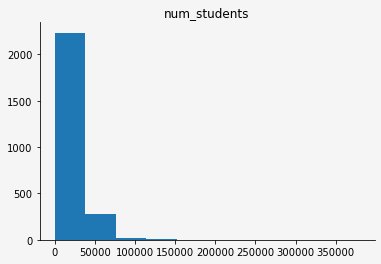

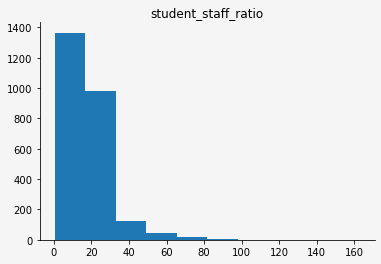

In [41]:
for feature in ['num_students', 'student_staff_ratio']:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(df[feature])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(feature)
    ax.set_facecolor(color='#f5f5f5')
    fig.patch.set_facecolor('#f5f5f5')

plt.show()

In [42]:
df.num_students.quantile([0, 0.01, 0.25, 0.5, 0.75, 0.99, 1])

0.00       462.00
0.01      2400.00
0.25     12637.75
0.50     20851.00
0.75     29991.00
0.99     83236.00
1.00    379231.00
Name: num_students, dtype: float64

Text(0.5, 1.0, 'Original Features Correlation with Ranking')

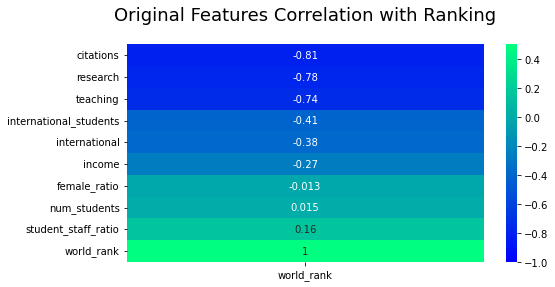

In [43]:
plt.figure(figsize=(8, 4))
heatmap = sns.heatmap(df.iloc[:, [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, -1]].corr()[['world_rank']].sort_values(by='world_rank'),
                     vmin=-1, vmax=0.5, annot=True, cmap='winter')

heatmap.set_title('Original Features Correlation with Ranking', fontdict={'fontsize': 18}, pad=24)



In [44]:
df = df[(df['num_students'] <= 100000) & 
            (df['student_staff_ratio'] <= 70)].copy()

In [45]:
nan_val_columns = ['num_students', 'student_staff_ratio', 'international_students', 'female_ratio',
                  'income', 'international']
for col in nan_val_columns:
    df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

### Testing all the regressors on the different years models

In [46]:
def reg_rsquare_func(model, df):
    # Filtering the years of the dataset
    df_2011 = df[df['year'] == 2011].copy()
    df_2012 = df[df['year'] == 2012].copy()
    df_2013 = df[df['year'] == 2013].copy()
    df_2014 = df[df['year'] == 2014].copy()
    df_2015 = df[df['year'] == 2015].copy()
    df_2016 = df[df['year'] == 2016].copy()
    # X values
    X_2011_train = df_2011.iloc[:, 4:].values
    X_2012 = df_2012.iloc[:, 4:].values
    X_2013 = df_2013.iloc[:, 4:].values
    X_2014 = df_2014.iloc[:, 4:].values
    X_2015 = df_2015.iloc[:, 4:].values
    X_2016 = df_2016.iloc[:, 4:].values
    # y values
    y_2011_train = df_2011.iloc[:, 0].values
    y_2012 = df_2012.iloc[:, 0].values
    y_2013 = df_2013.iloc[:, 0].values
    y_2014 = df_2014.iloc[:, 0].values
    y_2015 = df_2015.iloc[:, 0].values
    y_2016 = df_2016.iloc[:, 0].values
    # Splitting the datasets
    X_2012_train, X_2012_test, y_2012_train, y_2012_test = train_test_split(X_2012, y_2012, test_size=.2, random_state=0)
    X_2013_train, X_2013_test, y_2013_train, y_2013_test = train_test_split(X_2013, y_2013, test_size=.2, random_state=0)
    X_2014_train, X_2014_test, y_2014_train, y_2014_test = train_test_split(X_2014, y_2014, test_size=.2, random_state=0)
    X_2015_train, X_2015_test, y_2015_train, y_2015_test = train_test_split(X_2015, y_2015, test_size=.2, random_state=0)
    X_2016_train, X_2016_test, y_2016_train, y_2016_test = train_test_split(X_2016, y_2016, test_size=.2, random_state=0)
    
    rsquare_scores = list()
    index_years = list()
    
    for i in range(1, 7):
        reg_pipe = Pipeline(steps= [('scale', StandardScaler()), ('Reg model', model())])
        reg_pipe.fit(eval(f"X_201{i}_train"), eval(f"y_201{i}_train"))
        for j in range(1, 7):
            if i == j or i > j:
                continue
            else:
                rsquare_scores.append(reg_pipe.score(eval(f"X_201{j}_test"), eval(f"y_201{j}_test")))
                index_years.append(f"201{i}-201{j}")
    return [rsquare_scores, index_years]

In [47]:
reg_models = [LinearRegression, RandomForestRegressor, XGBRegressor, Lars, Ridge, GammaRegressor, SGDRegressor]

In [48]:
# Looping through everything
rsquare_data = list()
for model in reg_models:
    rsquare_data.append(reg_rsquare_func(model, df)[0])

In [49]:
df_rsquare = pd.DataFrame(np.array(rsquare_data).T, index=reg_rsquare_func(Lars, df)[1],
                          columns=['Linear Regression', 'Random Forest Reg', 'XGB Reg', 'Lars Reg',
                                          'Ridge Reg', 'Gamma Reg', 'SGD Reg'])

In [50]:
df_rsquare['year_difference'] = abs(df_rsquare.index.str[:4].astype(int) - df_rsquare.index.str[5:].astype(int))

In [51]:
df_rsquare.corr()

,Linear Regression,Random Forest Reg,XGB Reg,Lars Reg,Ridge Reg,Gamma Reg,SGD Reg,year_difference
Linear Regression,1.000000,0.932156,0.949965,0.982448,0.999993,0.096621,0.999966,-0.839445
Random Forest Reg,0.932156,1.000000,0.996976,0.898777,0.933202,-0.198838,0.932322,-0.698314
XGB Reg,0.949965,0.996976,1.000000,0.919434,0.950859,-0.156790,0.949997,-0.722666
Lars Reg,0.982448,0.898777,0.919434,1.000000,0.982306,0.086372,0.982408,-0.805997
Ridge Reg,0.999993,0.933202,0.950859,0.982306,1.000000,0.094309,0.999975,-0.838432
Gamma Reg,0.096621,-0.198838,-0.156790,0.086372,0.094309,1.000000,0.098438,-0.172366
SGD Reg,0.999966,0.932322,0.949997,0.982408,0.999975,0.098438,1.000000,-0.837568
year_difference,-0.839445,-0.698314,-0.722666,-0.805997,-0.838432,-0.172366,-0.837568,1.000000


In [52]:
df_rsquare.groupby('year_difference').median().mean()

Linear Regression    0.514350
Random Forest Reg    0.341862
XGB Reg              0.396813
Lars Reg             0.515785
Ridge Reg            0.513207
Gamma Reg            0.747036
SGD Reg              0.515552
dtype: float64

In [53]:
df_rsquare.groupby('year_difference').median().mean()

Linear Regression    0.514350
Random Forest Reg    0.341862
XGB Reg              0.396813
Lars Reg             0.515785
Ridge Reg            0.513207
Gamma Reg            0.747036
SGD Reg              0.515552
dtype: float64

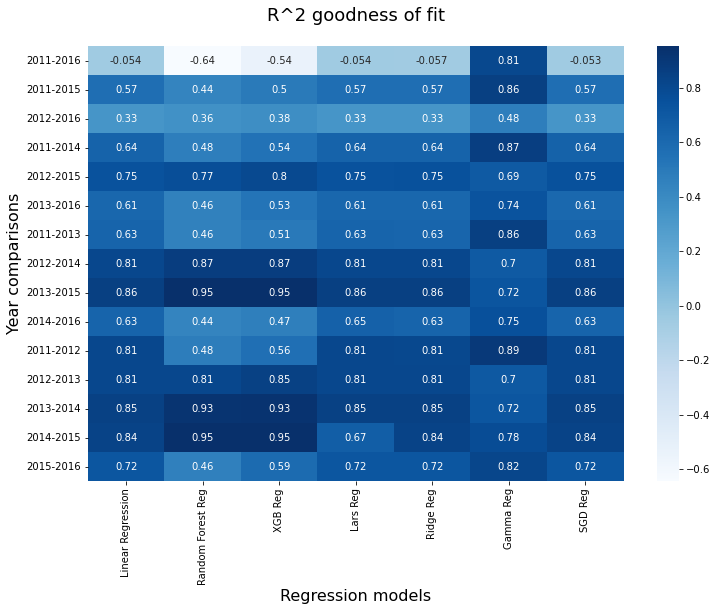

In [54]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_rsquare.sort_values('year_difference', ascending=False).iloc[:, :-1], annot=True, cmap='Blues')
plt.title('R^2 goodness of fit', size=18, pad=25)
# X axis
plt.xlabel('Regression models', size=16)
# y axis
plt.ylabel('Year comparisons', size=16)

plt.show()

In [55]:
df_rsquare

,Linear Regression,Random Forest Reg,XGB Reg,Lars Reg,Ridge Reg,Gamma Reg,SGD Reg,year_difference
2011-2012,0.810861,0.480460,0.562397,0.810861,0.809126,0.892027,0.811327,1
2011-2013,0.629815,0.459551,0.510427,0.629954,0.628275,0.859046,0.631832,2
2011-2014,0.640342,0.477731,0.543422,0.640417,0.639022,0.865673,0.642376,3
2011-2015,0.568732,0.436641,0.499220,0.568905,0.567973,0.856222,0.571415,4
2011-2016,-0.053979,-0.643795,-0.536767,-0.053813,-0.057447,0.809211,-0.052836,5
2012-2013,0.812082,0.813496,0.848557,0.812082,0.812672,0.702586,0.813787,1
2012-2014,0.812930,0.867971,0.869329,0.812930,0.813309,0.696375,0.813962,2
2012-2015,0.746523,0.768942,0.801019,0.746523,0.748127,0.693216,0.751649,3
2012-2016,0.331075,0.359596,0.378735,0.331075,0.330030,0.476333,0.329724,4
2013-2014,0.850913,0.926943,0.931758,0.850913,0.850933,0.719376,0.850433,1


In [56]:
df_rsquare.iloc[:, :-1].median()[df_rsquare.median() == df_rsquare.iloc[:, :-1].median().max()].index

Index(['Gamma Reg'], dtype='object')

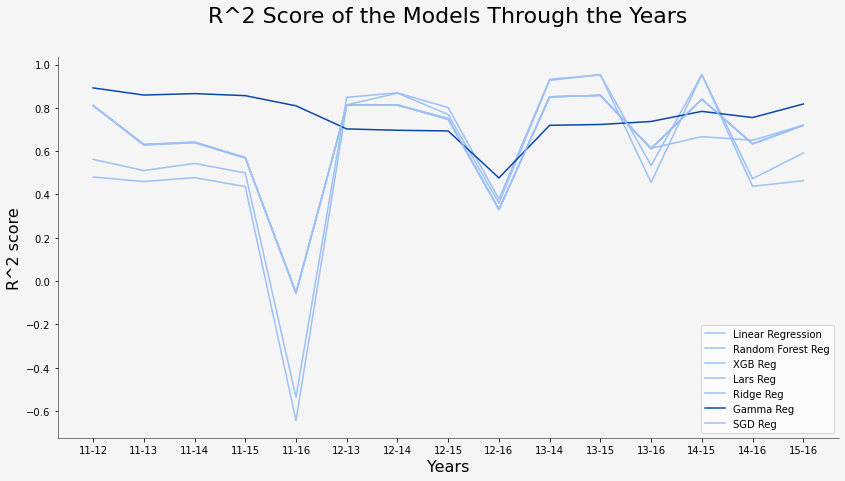

In [57]:
fig, ax = plt.subplots(figsize=(14, 7))

for i in range(len(df_rsquare.columns) - 1):
    if df_rsquare.median().index[i] == df_rsquare.iloc[:, :-1].median()[df_rsquare.median() == df_rsquare.iloc[:, :-1].median().max()].index:
        color = '#0746ab'
    else:
        color = '#9cc0f7'
    ax.plot(df_rsquare.index.str[2:4] + '-' + df_rsquare.index.str[7:9],
            df_rsquare.iloc[:, i], label=df_rsquare.columns[i],
            color=color)

# Y axis
ax.set_ylabel('R^2 score', size=16)

# X axis
ax.set_xlabel('Years', size=16)

plt.title('R^2 Score of the Models Through the Years', size=22, pad=35)

ax.set_facecolor(color='#f5f5f5')
fig.patch.set_facecolor('#f5f5f5')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

ax.legend(loc='lower right')

plt.show()

The figure above shows the relationship of the R2 score of the model with the rest of the years. The first two ticks on the x-axis show the year the model was trained, and the last two is which year the test set was tested on. For example, the first x-tick, ‘11-12’, had the regression models trained on the training set of the year 2011, and tested on the test set of the year 2012. On the ’11-16’ tick, there is a significant dip in most of the model’s performance, and some R2 values are below 0 which indicates that the trained models do not follow the trend of the testing set, in those situations. A reason for this strong dip in this period is that the weights of the ranking are changing each year, and the larger the difference in years, usually the larger the gaps will be.

## Implementing gamma regression for prediction future university ranking

In [58]:
sgd_reg_pipe = Pipeline([('scaler', StandardScaler()),
                         ('SGD reg', SGDRegressor(random_state=0))])

In [59]:
df_2016 = df[df['year'] == 2016].copy()
X_2016 = df_2016.iloc[:, 4:].values
y_2016 = df_2016.iloc[:, 0].values
X_2016_train, X_2016_test, y_2016_train, y_2016_test = train_test_split(X_2016,
                                            y_2016, test_size=.2, random_state=0)

In [60]:
sgd_reg_pipe.fit(X_2016_train, y_2016_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('SGD reg', SGDRegressor(random_state=0))])

In [61]:
df.columns

Index(['world_rank', 'year', 'university_name', 'country', 'teaching',
       'international', 'research', 'citations', 'income', 'num_students',
       'student_staff_ratio', 'international_students', 'Africa', 'Asia',
       'Europe', 'North America', 'Oceania', 'South America', 'UK',
       'female_ratio'],
      dtype='object')

American-based global university rankings have been known for English-speaking university bias. The dataset doesn't provide the main language of the universities, but segmenting them into their continents, could provide some information if this claim is true.

## Checking for systematic bias for continents

In [62]:
continent_converter_dic = {'Africa': [1 if i == 0 else 0 for i in range(7)], 
                           'Asia': [1 if i == 1 else 0 for i in range(7)], 
                           'Europe': [1 if i == 2 else 0 for i in range(7)],
                           'North America': [1 if i == 3 else 0 for i in range(7)],
                           'Oceania': [1 if i == 4 else 0 for i in range(7)],
                           'South America': [1 if i == 5 else 0 for i in range(7)],
                           'United Kingdom': [1 if i == 6 else 0 for i in range(7)]}

In [63]:
def univ_predictor_func(num_features:list, num_students:int, student_staff, inter:int,  continent:str, fem_ratio):
    lister = list()
    for i in [num_features, num_students, student_staff, inter, continent_converter_dic[continent], fem_ratio]:
        if type(i) == list:
            for j in i:
                lister.append(j)
        else:
            lister.append(i)
    return round(float(sgd_reg_pipe.predict(np.array(lister)
                                                        .reshape(1, -1))), 4)

In [64]:
lister = list()
for i in range(100):
    # features
    arr = np.random.rand(1, 5) * 100
    # Number of students
    arr = np.append(arr, np.random.uniform(500, 100000))
    # student staff ratio
    arr = np.append(arr, np.random.uniform() * 100)
    # International
    arr = np.append(arr, np.random.uniform() * 100)
    # continent
    afr_array = np.append(arr, [i for i in continent_converter_dic['Africa']])
    asi_array = np.append(arr, [i for i in continent_converter_dic['Asia']])
    eu_array = np.append(arr, [i for i in continent_converter_dic['Europe']])
    na_array = np.append(arr, [i for i in continent_converter_dic['North America']])
    oce_array = np.append(arr, [i for i in continent_converter_dic['Oceania']])
    sa_array = np.append(arr, [i for i in continent_converter_dic['South America']])
    uk_array = np.append(arr, [i for i in continent_converter_dic['United Kingdom']])
    
    # female ratio
    fem_rand = np.random.uniform() * 100
    # Adding female ratio
    afr_array = np.append(afr_array, fem_rand)
    asi_array = np.append(asi_array, fem_rand)
    eu_array = np.append(eu_array, fem_rand)
    na_array = np.append(na_array, fem_rand)
    oce_array = np.append(oce_array, fem_rand)
    sa_array = np.append(sa_array, fem_rand)
    uk_array = np.append(uk_array, fem_rand)
    lister.append([float(sgd_reg_pipe.predict(afr_array.reshape(1, -1))) - float(sgd_reg_pipe.predict(na_array.reshape(1, -1))),
                   float(sgd_reg_pipe.predict(asi_array.reshape(1, -1))) - float(sgd_reg_pipe.predict(na_array.reshape(1, -1))),
                   float(sgd_reg_pipe.predict(eu_array.reshape(1, -1))) - float(sgd_reg_pipe.predict(na_array.reshape(1, -1))),
                   float(sgd_reg_pipe.predict(oce_array.reshape(1, -1))) - float(sgd_reg_pipe.predict(na_array.reshape(1, -1))),
                   float(sgd_reg_pipe.predict(sa_array.reshape(1, -1))) - float(sgd_reg_pipe.predict(na_array.reshape(1, -1))), 
                   float(sgd_reg_pipe.predict(uk_array.reshape(1, -1))) - float(sgd_reg_pipe.predict(na_array.reshape(1, -1)))])
    

In [65]:
arr = np.array(lister)

In [66]:
df_arrs = pd.DataFrame(arr, columns=['Africa', 'Asia', 'Europe', 'Oceania', 'South America',
                                    'United Kingdom'])

In [67]:
df_arrs

,Africa,Asia,Europe,Oceania,South America,United Kingdom
0,4.062411,-0.92715,-1.262579,1.954334,-5.810216,5.757514
1,4.062411,-0.92715,-1.262579,1.954334,-5.810216,5.757514
2,4.062411,-0.92715,-1.262579,1.954334,-5.810216,5.757514
3,4.062411,-0.92715,-1.262579,1.954334,-5.810216,5.757514
4,4.062411,-0.92715,-1.262579,1.954334,-5.810216,5.757514
...,...,...,...,...,...,...
95,4.062411,-0.92715,-1.262579,1.954334,-5.810216,5.757514
96,4.062411,-0.92715,-1.262579,1.954334,-5.810216,5.757514
97,4.062411,-0.92715,-1.262579,1.954334,-5.810216,5.757514
98,4.062411,-0.92715,-1.262579,1.954334,-5.810216,5.757514


In [68]:
colors = ['#9ff5b6', '#e6c297', '#b5c7e8', '#e4c4f5', '#f5c4d6', '#0746ab']

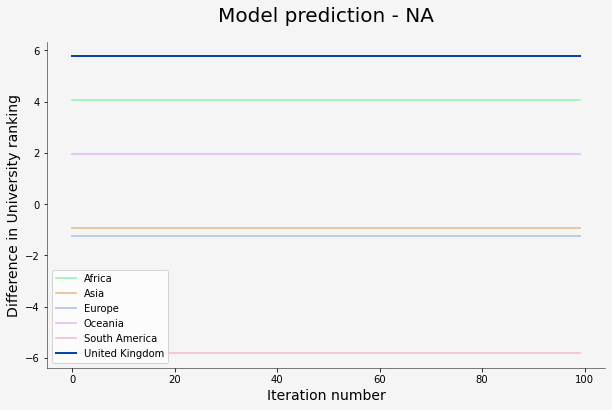

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))
for col in range(len(df_arrs.T)):
    if df_arrs.columns[col] == 'United Kingdom':
        linewidth=2
    else: 
        linewidth=1.8
    ax.plot(np.arange(0, 100), df_arrs.iloc[:, col], linewidth=linewidth,
            label=df_arrs.columns[col], color=colors[col])

# X axis
ax.set_xlabel('Iteration number', size=14)

# y axis
ax.set_ylabel('Difference in University ranking', size=14)
#ax.set_yticks(np.round(np.linspace(-3, 7, 11), 2))

plt.title('Model prediction - NA', size=20, pad=20)

ax.set_facecolor(color='#f5f5f5')
fig.patch.set_facecolor('#f5f5f5')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

ax.legend()
plt.show()

The data visualization above is quite surprising when looking at the difference the model has in predicting university rankings between North American universities, and universities from the UK. The x-axis is the number of iterations it was, and the y-axis shows the difference in predicted university ranking. As the output displays, the differences are constant, so it would not matter if the number of iterations was different. The gamma regression has a constant of +5.75 when subtracting the model’s prediction of North American universities against UK universities (Fig. 4). This means that when the model sees the university is in the UK, it predicts a 5.75 worse ranking than if it was a university in North America. Other continents such as South America have -5.81 in difference, meaning the rankings are predicting an improved rating than if the university was in South America.

In [70]:
len(df[df['South America'] == 1])

38

In [71]:
university_predictor_data = list()
for i in range(len(df.columns)):
    if i in [0, 1, 2, 3, 13, 14, 15, 16, 17, 18]:
        continue
    elif df.columns[i] == 'Africa':
        try:
            print("Type in one of these continents, or if it's in the UK, United Kingdom")
            for key in continent_converter_dic:
                print(key)
            for i in continent_converter_dic[input("Enter the continent: ")]:
                university_predictor_data.append(i)
        except:
            ValueError("The value needs to be a continent, or United Kingdom")
    else:
        university_predictor_data.append(int(input(f"Enter data for {df.columns[i]}: \t")))

Enter data for teaching: 	45
Enter data for international: 	56
Enter data for research: 	70
Enter data for citations: 	45
Enter data for income: 	70
Enter data for num_students: 	20000
Enter data for student_staff_ratio: 	30
Enter data for international_students: 	30
Type in one of these continents, or if it's in the UK, United Kingdom
Africa
Asia
Europe
North America
Oceania
South America
United Kingdom
Enter the continent: Europe
Enter data for female_ratio: 	50


In [72]:
print("Predicted rank is: ", round(float(sgd_reg_pipe.predict(np.array(university_predictor_data)
                                                        .reshape(1, -1))), 4))

Predicted rank is:  252.0015
